#### Script Description
This script loads a pre-processed dataset, and computes the Potentail Evapotranspiration and Reference Evapotranspiration. 

*File Name:* 01_08_Compute_Evapotranspiration.ipynb

*Date:* 2025

*Created by:* Rob Alamgir  

*Version:* 1.0

*References:*

#### Import relevant packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyet
from pyet import penman
from pyet import abtew

# Use help() to view the available arguments
#help(pyet.penman)
#help(pyet.abtew)

### Step 1: Data Preprocessing

In [2]:
# Load preprocessed Dataset
Complete_Data = pd.read_csv("C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locaions_Updated_2.csv")

# Convert 'Date' column to datetime format and encode 'Source' as numeric codes
Complete_Data['Date'] = pd.to_datetime(Complete_Data['Date'], format='%Y-%m-%d')

# Filter dataset from 2020 onwards 
filtered_df = Complete_Data[Complete_Data['Date'] >= '2020-01-01']

# Load NOBV data
NOBV_Site_Data = pd.read_csv("C:/Data_MSc_Thesis/NOBV_Site_Data/NOBV_EC_Tower_Data_Final.csv")

# Merge the two dataframes based on 'Source' and 'Site_ID'
merged_df = pd.merge(filtered_df, 
                     NOBV_Site_Data[['Site_ID', 'EPSG_4326_WGS_84_Longitude_X', 'EPSG_4326_WGS_84_Latitude_Y','Elevation_m']],
                     left_on='Source', right_on='Site_ID', how='left')

# Check if the 'Source' and 'Site_ID' columns match in the merged dataframe
merged_df['Source_matches_Site_ID'] = merged_df['Source'] == merged_df['Site_ID']
#print(merged_df[merged_df['Source_matches_Site_ID'] == False])

# Remove unnecessary columns for analysis
filtered_df_V1  = merged_df.drop(columns=[ 'Source','Source_matches_Site_ID'])

# Preprocess the input data
filtered_df_V2  = pd.DataFrame({"Date":filtered_df_V1.Date,
                                "Site_ID":filtered_df_V1.Site_ID,
                                "T":filtered_df_V1.ATMP_f,                  # temperature in [C°]
                                "RH":filtered_df_V1.RHUM_f,                 # relative_humidity [%°]
                                "R":filtered_df_V1.SWIN_f*0.0864,           # convert solar radiation from [(W/m^2)day^1] to [MJ m-2 d-1]
                                "u2":filtered_df_V1.WINS_f,                 # windspeed [m/s]
                                "PAIR":filtered_df_V1.PAIR_f*0.1,           # convert air pressure in [hPa] to [kPa]
                                "latitude":filtered_df_V1.EPSG_4326_WGS_84_Latitude_Y,
                                "Elevation":filtered_df_V1.Elevation_m})    # Elevation in [m] # Latitude of the meteorological station

#### Check structure and presence of NaNs in filtered_df_V2 dataframe

In [3]:
#print(filtered_df_V2.head(30))
#print(filtered_df_V2.describe())
#print(filtered_df_V2.columns)

# Check the structure of all columns (data types)
#print(filtered_df_V2.dtypes)

# Check for missing values (NaNs) in each column
#print(filtered_df_V2.isnull().sum())

#### Remove NaNs from filtered_df_V2 dataframe

In [4]:
# Remove rows with NaN values
filtered_df_V3 = filtered_df_V2.dropna()
# Check the structure of all columns (data types)
#print(filtered_df_V3.dtypes)

# Check for missing values (NaNs) in each column
#print(filtered_df_V3.isnull().sum())

### Step 2: Calculate Potential Evapotranspiration (PET) using Makkink method 

In [8]:
# Calculate Potential Evapotranspiration (PET) using Makkink method for all rows at once (vectorized)
filtered_df_V3.loc[:, 'PET'] = pyet.makkink(
    tmean=filtered_df_V3['T'], 
    rs=filtered_df_V3['R'], 
    pressure=filtered_df_V3['PAIR'],
    elevation=filtered_df_V3['Elevation'],
    clip_zero=False)  # Avoid clipping of negative values

# Display the first few rows of the dataframe
#print(filtered_df_V3.head())

# Summary statistics of the dataframe
print(filtered_df_V3.describe())

                             Date            T           RH            R  \
count                        8873  8873.000000  8873.000000  8873.000000   
mean   2022-11-15 15:44:02.488448    10.921535    85.944046    10.811133   
min           2021-07-12 00:00:00    -4.192153    42.140405     0.000000   
25%           2022-04-02 00:00:00     6.742938    80.135208     3.359830   
50%           2022-11-10 00:00:00    10.452847    87.241666     8.757444   
75%           2023-06-27 00:00:00    15.744326    92.693750    16.962898   
max           2024-05-13 00:00:00    26.741347   100.000000    42.679000   
std                           NaN     5.724241     8.839232     8.386374   

                u2         PAIR     latitude    Elevation          PET  
count  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000  
mean      3.339160   101.467282    53.042338    -0.281787     1.701625  
min       0.111722    97.416408    52.986210    -1.300000     0.000000  
25%       2.166562   10

#### Plot the Potential Evapotranspiration (PET) for all locations

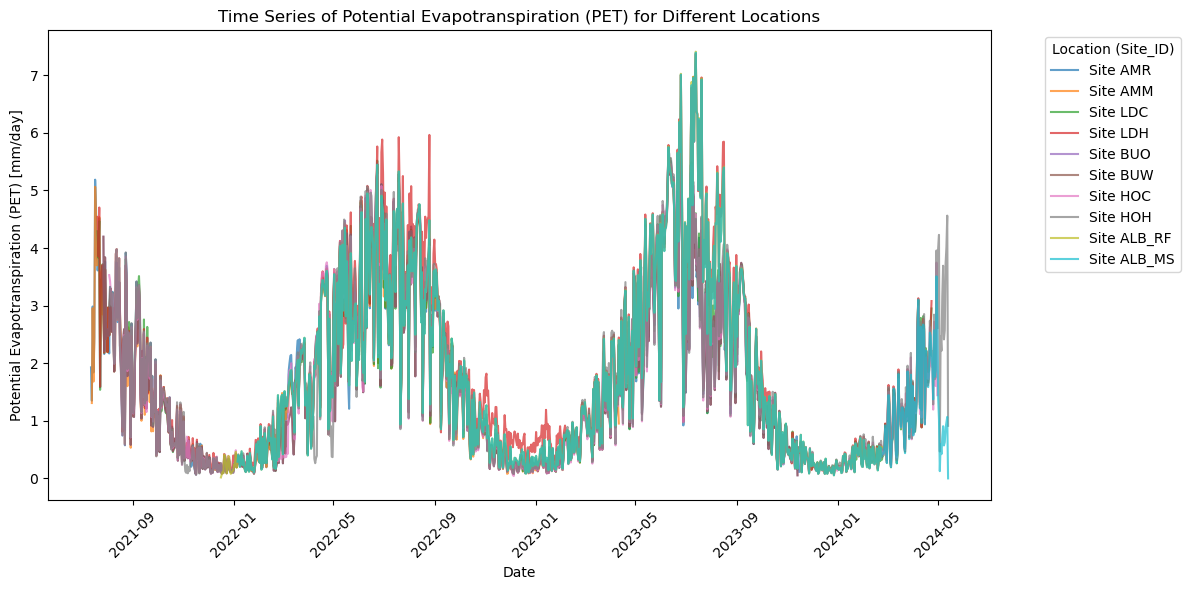

In [16]:
# Set up the figure and axis for the plots
plt.figure(figsize=(12, 6))

# Get the unique Site_IDs
site_ids = filtered_df_V3['Site_ID'].unique()

# Iterate through each Site_ID and plot PET for that location
for site in site_ids:
    # Filter data for each location
    site_data = filtered_df_V3[filtered_df_V3['Site_ID'] == site]
    
    # Plot the PET for the current Site_ID
    plt.plot(site_data['Date'], site_data['PET'], label=f'Site {site}', alpha=0.7)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Potential Evapotranspiration (PET) [mm/day]')
plt.title('Time Series of Potential Evapotranspiration (PET) for Different Locations')
plt.legend(title='Location (Site_ID)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Plot histogram of Potential Evapotranspiration (PET)

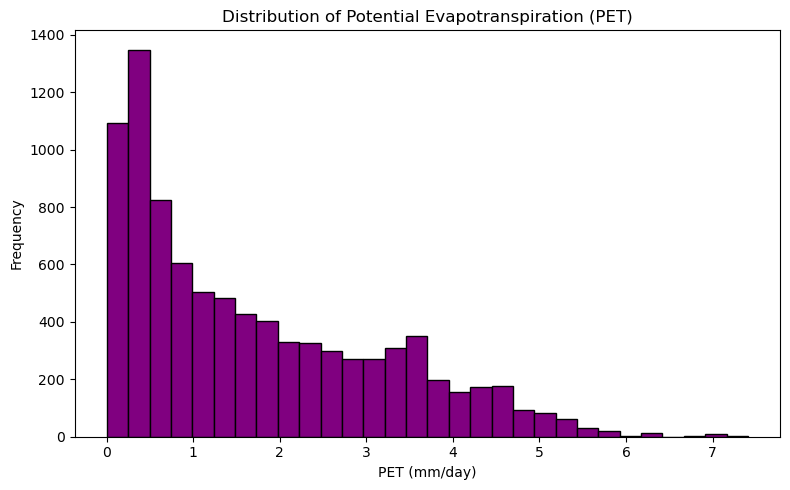

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(filtered_df_V3['PET'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Potential Evapotranspiration (PET)')
plt.xlabel('PET (mm/day)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Step 3: Calculate reference evapotranspiration (ETo) using abtew method

In [13]:
# Calculate ET0 using Abtew method for all rows at once (vectorized) and add it directly to the original DataFrame
filtered_df_V3.loc[:, 'ET0'] = abtew(
    tmean=filtered_df_V3['T'],  # Average daily temperature in °C
    rs=filtered_df_V3['R'],     # Solar radiation in MJ m²/day
    clip_zero=True)             # Option to clip negative values (optional)

# Display the first few rows to check the results
#print(filtered_df_V3[['Date', 'Site_ID', 'ET0']].head())

# Summary statistics of the dataframe
print(filtered_df_V3.describe())

                             Date            T           RH            R  \
count                        8873  8873.000000  8873.000000  8873.000000   
mean   2022-11-15 15:44:02.488448    10.921535    85.944046    10.811133   
min           2021-07-12 00:00:00    -4.192153    42.140405     0.000000   
25%           2022-04-02 00:00:00     6.742938    80.135208     3.359830   
50%           2022-11-10 00:00:00    10.452847    87.241666     8.757444   
75%           2023-06-27 00:00:00    15.744326    92.693750    16.962898   
max           2024-05-13 00:00:00    26.741347   100.000000    42.679000   
std                           NaN     5.724241     8.839232     8.386374   

                u2         PAIR     latitude    Elevation          PET  \
count  8873.000000  8873.000000  8873.000000  8873.000000  8873.000000   
mean      3.339160   101.467282    53.042338    -0.281787     1.701625   
min       0.111722    97.416408    52.986210    -1.300000     0.000000   
25%       2.166562 

#### Plot the reference evapotranspiration (ETo) for all locations

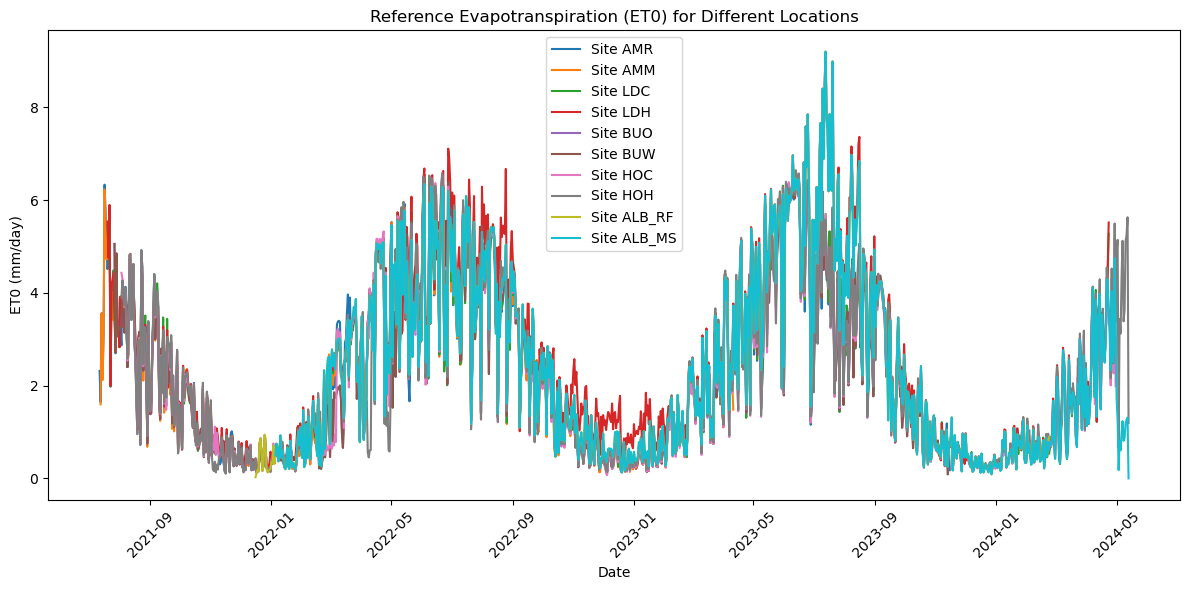

In [14]:
# Plot ET0 for all locations
plt.figure(figsize=(12, 6))
for site_id in filtered_df_V3['Site_ID'].unique():
    site_data = filtered_df_V3[filtered_df_V3['Site_ID'] == site_id]
    plt.plot(site_data['Date'], site_data['ET0'], label=f"Site {site_id}")

plt.xlabel('Date')
plt.ylabel('ET0 (mm/day)')
plt.title('Reference Evapotranspiration (ET0) for Different Locations')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Plot Potential Evapotranspiration (PET) & reference evapotranspiration (ETo)

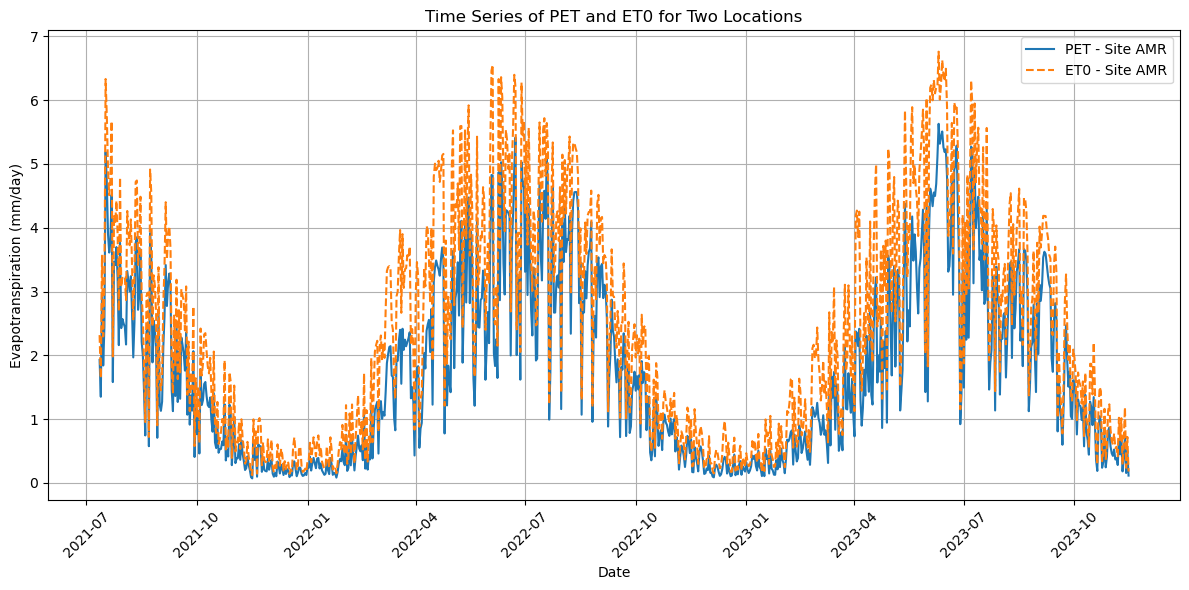

In [15]:
# Choose the two locations you want to plot (example: Site_ID 1 and Site_ID 2)
locations = ['AMR']  # Replace with the actual Site_IDs you want to plot

# Filter the data for these locations
filtered_locations_df = filtered_df_V3[filtered_df_V3['Site_ID'].isin(locations)]

# Plotting PET and ET0 for the two locations
plt.figure(figsize=(12, 6))

for site in locations:
    site_data = filtered_locations_df[filtered_locations_df['Site_ID'] == site]
    
    # Plot PET and ET0 for this site
    plt.plot(site_data['Date'], site_data['PET'], label=f'PET - Site {site}')
    plt.plot(site_data['Date'], site_data['ET0'], label=f'ET0 - Site {site}', linestyle='--')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Evapotranspiration (mm/day)')
plt.title('Time Series of PET and ET0 for Two Locations')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Step 4: Export the final dataframe to a CSV file

In [19]:
output_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Computed_PET_ET0.csv"  # Update the path as needed
filtered_df_V3.to_csv(output_path, index=False)

print(f"DataFrame successfully saved to {output_path}")

DataFrame successfully saved to C:/Data_MSc_Thesis/Pre_Processed_Data/Computed_PET_ET0.csv
